In [5]:
import pandas as pd
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
loadings = pd.read_csv("asv_loadings_pcoa.csv", index_col = 0)
sig_res = pd.read_csv("../significant_taxa_timeseries.tsv", sep = "\t", index_col = 0)

In [12]:
sig_res = sig_res.loc[["," in i for i in sig_res.method], :]
aut_sig_res = sig_res.loc[sig_res.enrichment == "Aut,Aut", :]
nt_sig_res = sig_res.loc[sig_res.enrichment == "Control,Control", :]
gene_set = {}
gene_set['aut'] = aut_sig_res.index.values
gene_set['nt'] = nt_sig_res.index.values

In [13]:
pvals_aut = {}
pvals_nt =  {}
results_dict = {}
for i in np.arange(loadings.shape[1]):
    prerank = loadings.iloc[:, i]
    results = gp.prerank(rnk = prerank, gene_sets = gene_set, permutation_num = 10, min_size = 0, max_size = 10000, verbose= True)
    pvals_aut[loadings.columns.values[i]] = results.results['aut']['fdr']
    pvals_nt[loadings.columns.values[i]] = results.results['nt']['fdr']
    results_dict[loadings.columns.values[i]] = results
 

2021-08-10 13:20:05,180 Parsing data files for GSEA.............................
2021-08-10 13:20:05,183 0000 gene_sets have been filtered out when max_size=10000 and min_size=0
2021-08-10 13:20:05,184 0002 gene_sets used for further statistical testing.....
2021-08-10 13:20:05,185 Start to run GSEA...Might take a while..................
2021-08-10 13:20:05,190 Start to generate gseapy reports, and produce figures...
2021-08-10 13:20:06,025 Congratulations. GSEApy runs successfully................

2021-08-10 13:20:06,030 Parsing data files for GSEA.............................
2021-08-10 13:20:06,032 0000 gene_sets have been filtered out when max_size=10000 and min_size=0
2021-08-10 13:20:06,033 0002 gene_sets used for further statistical testing.....
2021-08-10 13:20:06,033 Start to run GSEA...Might take a while..................
2021-08-10 13:20:06,039 Start to generate gseapy reports, and produce figures...
2021-08-10 13:20:06,714 Congratulations. GSEApy runs successfully..........

In [14]:
def plotHeatmap(axis, phenotype):
    prerank1 = pd.DataFrame(loadings)
    prerank1 = pd.DataFrame(prerank1.loc[:, axis])

    prerank1 = prerank1.sort_values(axis, ascending=False)
    gene_set = {'aut': np.squeeze(aut_sig_res.index.values), 'nt': np.squeeze(nt_sig_res.index.values)}

    taxa_names_df = sig_res.loc[gene_set[phenotype], :]
    taxa_names_df['full_name'] = taxa_names_df[['Family', 'Genus', 'Species']].agg(' '.join, axis = 1)
    taxa_names_df['id'] = np.arange(taxa_names_df.shape[0])
    labels = [taxa_names_df.loc[i, 'full_name'] if i in gene_set[phenotype] else "" for i in prerank1.index.values ]
    #labels = [taxa_names_df.loc[i,'id'] if i in gene_set[phenotype] else "" for i in prerank1.index.values ]

    sns.set(font_scale = 1)
    p = sns.heatmap(prerank1, annot = False,
                    cmap = "viridis",
                    xticklabels = False, yticklabels = labels).set_title(axis)
    return(p)

Axis.48
Axis.40
Axis.1


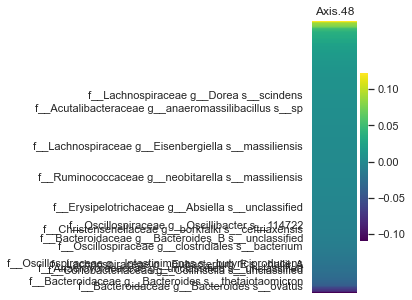

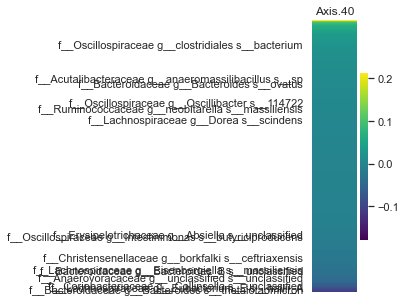

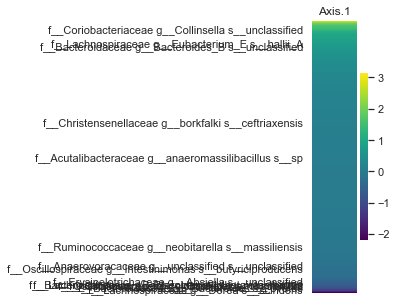

In [15]:
for axis in loadings.columns.values:
    if pvals_aut[axis] < 0.05:
        print(axis)
        plt.figure(figsize = (1, 5))
        p = plotHeatmap(axis, phenotype = "aut")
        plt.savefig(axis + ".svg")
        

In [ ]:
for axis in loadings.columns.values:
    if pvals_aut[axis] < 0.05:
        print(axis)
        results = results_dict[axis]
        gp.gseaplot(rank_metric = loadings.loc[:, axis].sort_values(ascending = False), term = "aut", **results.results['aut'])
    if pvals_nt[axis] < 0.05:
        print(axis)
        results = results_dict[axis]
        gp.gseaplot(rank_metric = loadings.loc[:, axis].sort_values(ascending = False), term = "nt", **results.results['nt'])

In [ ]:
def getPlotData(phenotype):
    loadings = pd.read_csv("asv_loadings_pcoa.csv", index_col = 0)
    prerank1 = pd.DataFrame(loadings)
    prerank1.head()
    
    if phenotype == "aut":
        sig_axes = [axis for i,axis in zip(pvals_aut.values(), pvals_aut.keys()) if i < .05]
    if phenotype == "nt":
        sig_axes = [axis for i,axis in zip(pvals_nt.values(), pvals_nt.keys()) if i < .05]
    prerank1 = prerank1.loc[: , sig_axes]
    
    
    prerank1['biomarker'] = ['None'] * prerank1.shape[0]
    prerank1.loc[gene_set[phenotype], 'biomarker'] = phenotype
    
    prerank1 = prerank1.melt(['biomarker'])
    
    return(prerank1)

In [ ]:
print(sig_axes_aut)
print(sig_axes_nt)

In [ ]:
aut_data = getPlotData('aut')

plt.figure(figsize = (20, 14))
sns.set(font_scale = 1.5)
palette = {"aut":"#84CF04", "None": "grey"}
g = sns.FacetGrid(aut_data, col = "variable", col_wrap = 1,
                  hue="biomarker", size = 4, sharex = False, sharey = False, palette = palette)
g.map(sns.distplot, "value", hist = False, rug = True)
g.add_legend()

In [ ]:
nt_data = getPlotData('nt')

plt.figure(figsize = (20, 14))
sns.set(font_scale = 1.5)
palette = {"nt":  "#01B5BB", "None": "grey"}
g = sns.FacetGrid(nt_data, col = "variable", col_wrap = 1, hue="biomarker", size = 4, sharex = False, sharey = False, palette = palette)
g.map(sns.distplot, "value", hist = False, rug = True)
g.add_legend()


Axis.40
Axis.27
Axis.12


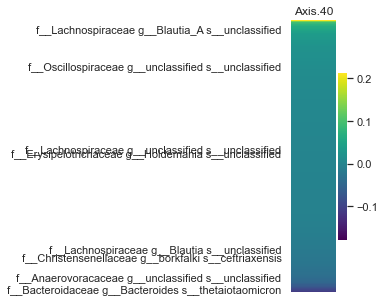

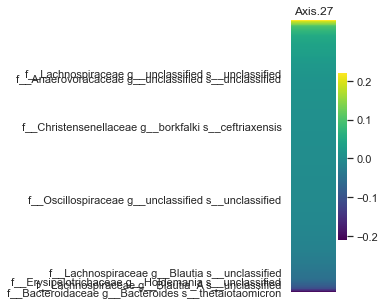

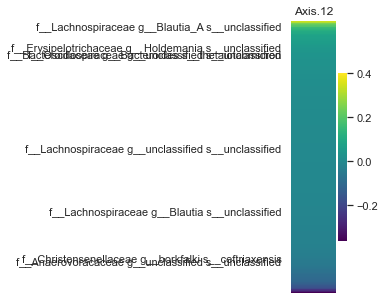

Axis.29
Axis.1
Axis.6


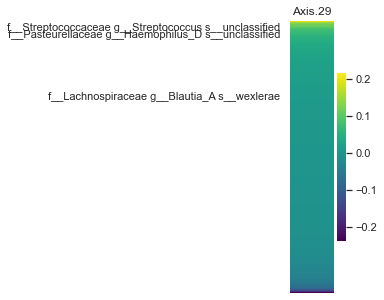

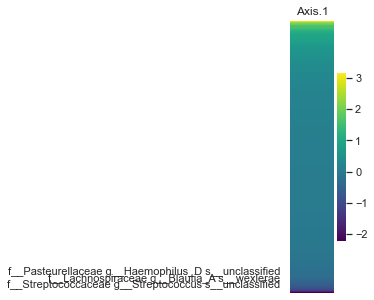

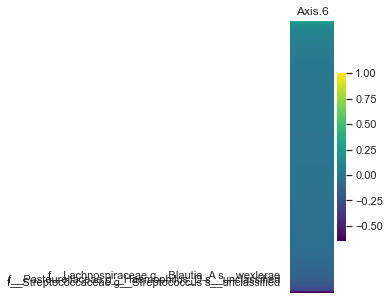

In [351]:
for axis in loadings.columns.values:
    if pvals_nt[axis] < 0.05:
        print(axis)
        plt.figure(figsize = (1, 5))
        plotHeatmap(axis, phenotype = "nt")
        plt.savefig(axis + ".svg")
        

In [98]:
print(loadings.columns[[i < .05 for i in pvals_aut]])
print(loadings.columns[[i < .05 for i in pvals_nt]])
i = 0
results = gp.prerank(rnk = prerank, gene_sets = gene_set, permutation_num = 10, min_size = 0, max_size = 10000, verbose= True)


2021-08-06 16:11:18,815 Parsing data files for GSEA.............................
2021-08-06 16:11:18,817 0000 gene_sets have been filtered out when max_size=10000 and min_size=0
2021-08-06 16:11:18,817 0002 gene_sets used for further statistical testing.....
2021-08-06 16:11:18,818 Start to run GSEA...Might take a while..................
2021-08-06 16:11:18,822 Start to generate gseapy reports, and produce figures...


Index(['Axis.48', 'Axis.43', 'Axis.27'], dtype='object')
Index(['Axis.29', 'Axis.1'], dtype='object')


2021-08-06 16:11:19,398 Congratulations. GSEApy runs successfully................



In [107]:
loadings.iloc[:, 0].sort_values(ascending = False)

CCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGTTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGCGACCTTGAGTGCAACAGAGGTAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTACTGGATTGTAACTGACGCTGATGCTCGAAAGTGTGGGT    0.122249
t__83170                                                                                                                                                                                                                                     0.120591
GCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGGACTGCAAGTTGGATGTGAAATACCGTGGCTTAACCACGGAACTGCATCCAAAACTGTAGTTCTTGAGTGAAGTAGAGGCAAGCGGAATTCCGAGTGTAGCGGTGAAATGCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGGCTTTAACTGACGCTGAGGCTCGAAAGTGTGGGG    0.100546
ACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGT    0.097522
CCGAGCGTTATCCGGA

In [105]:
results.ranking

gene_name
GCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCTGCGCCGGGTACGGGCGGGCTGGAGTGCGGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCCGTTACTGACGCTGAGGAGCGAAAGCGTGGGG    0.411890
GCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCGCGCCGGGTACGGGCGGGCTTGAGTGCGGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCCGTTACTGACGCTGAGGAGCGAAAGCGTGGGG    0.286156
CCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGCAGTCTTGAGTGCAGTAGAGGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGTGTAACTGACGCTGATGCTCGAAAGTGTGGGT    0.286066
TCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATCCCGGGGCTTAACTCCGGAACTGCCTCTAATACTGTTAGACTAGAGAGTAGTTGCGGTAGGCGGAATGTATGGTGTAGCGGTGAAATGCTTAGAGATCATACAGAACACCGATTGCGAAGGCAGCTTACCAAACTATATCTGACGTTGAGGCACGAAAGCGTGGGG    0.276138
GCGAGC

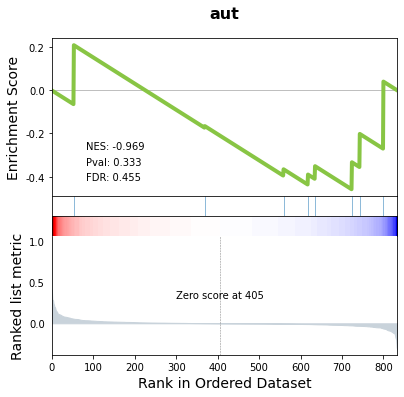

In [109]:
gp.gseaplot(rank_metric = results.ranking, term = "aut", **results.results['aut'])

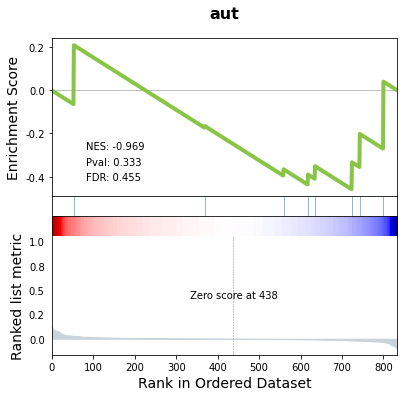

In [108]:
gp.gseaplot(rank_metric = loadings.iloc[:, 0].sort_values(ascending = False), term = "aut", **results.results['aut'])